In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch, torch.nn as nn
import torchvision

from copy import copy
from IPython import display
from IPython.display import clear_output
from PIL import Image
from skimage import color, transform
from sklearn.metrics import roc_auc_score
from time import time, sleep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cpu'

In [3]:
fmnist_train_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True,
                                                     transform=transforms.Compose([transforms.ToTensor()]))
fmnist_test_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True, train=False,
                                                    transform=transforms.Compose([transforms.ToTensor()]))
fmnist_train_data = DataLoader(fmnist_train_set, batch_size=32)
fmnist_test_data = DataLoader(fmnist_test_set, batch_size=32)

In [4]:
mnist_train_set = torchvision.datasets.MNIST("./data_mnist", download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_data = DataLoader(mnist_train_set, batch_size=32)
mnist_test_data = DataLoader(mnist_test_set, batch_size=32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.block_1_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.block_1_relu = nn.ReLU()
        self.block_1_max_pool = nn.MaxPool2d(kernel_size=2)

        self.block_2_conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.block_2_relu = nn.ReLU()
        self.block_2_max_pool = nn.MaxPool2d(kernel_size=2)
        self.block_2_batch_norm = nn.BatchNorm2d(num_features=16)

        self.block_3_flatten = nn.Flatten()
        self.block_3_linear = nn.Linear(in_features=400, out_features=100)
        self.block_3_relu = nn.ReLU()

        self.block_4_linear = nn.Linear(in_features=100, out_features=10)
        self.block_4_log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.block_1_conv(x)
        x = self.block_1_relu(x)
        x = self.block_1_max_pool(x)

        x = self.block_2_conv(x)
        x = self.block_2_relu(x)
        x = self.block_2_max_pool(x)
        x = self.block_2_batch_norm(x)

        x = self.block_3_flatten(x)
        x = self.block_3_linear(x)
        x = self.block_3_relu(x)

        x = self.block_4_linear(x)
        x = self.block_4_log_softmax(x)
        return x

In [6]:
def validate(teacher, student, data):
    teacher.eval()
    student.eval()
    total_img = 0
    loss = 0
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss += reverse_kl(teacher_pred, student_pred).item()
    return round(loss / total_img, 5)

In [7]:
def plot_results(train_log, val_log, test_log):
    clear_output(wait=True)
    print("Epoch", len(train_log))
    print("Train loss:\t", train_log[-1])
    print("Val loss:\t", val_log[-1])
    print("Test loss:\t", test_log[-1])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_log, label='train loss', c='b')
    ax1.plot(val_log, label='val loss', c='r')
    ax1.grid()
    ax1.legend(loc='best')

    ax2.plot(test_log, label='test_loss', c='g')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

In [8]:
def cross_entroy_with_logits(teacher_pred, student_pred):
    return -torch.sum(torch.exp(teacher_pred) * student_pred, dim=1).mean()

In [9]:
def forward_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(teacher_pred) * (teacher_pred - student_pred))

In [10]:
def reverse_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(student_pred) * (student_pred - teacher_pred))

In [11]:
def symmetrized_kl(teacher_pred, student_pred):
    return forward_kl(student_pred, teacher_pred) + revrse_kl(student_pred, teacher_pred)

In [12]:
def train(teacher, student, optimizer, train_log, val_log, test_log, num_epochs=30, batch_size=32):
    for epoch in range(num_epochs):
        teacher.train()
        student.train()
        for images, _ in tqdm(fmnist_train_data):
            # Transfering images and labels to GPU if available
            images = images.view(-1, 1, 28, 28).to(device)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss = reverse_kl(student_pred, teacher_pred)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_log.append(validate(teacher, student, fmnist_train_data))
        val_log.append(validate(teacher, student, fmnist_test_data))
        test_log.append(validate(teacher, student, mnist_train_data))
        plot_results(train_log, val_log, test_log)

In [13]:
train_log = []
val_log = []
test_log = []

In [14]:
teacher = ConvNet().to(device)
student = ConvNet().to(device)

In [15]:
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001)

Epoch 50
Train loss:	 0.00132
Val loss:	 0.00156
Test loss:	 0.01371


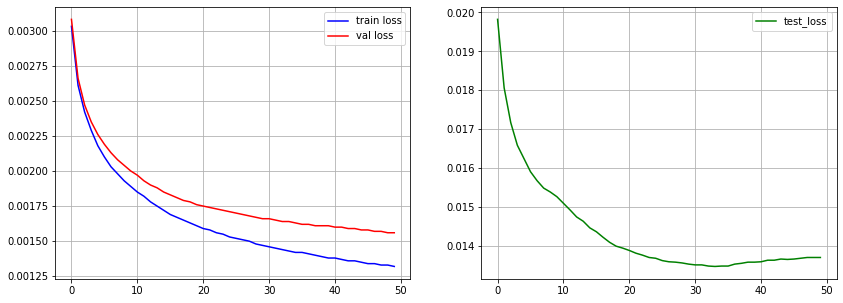

CPU times: user 3h 50min 7s, sys: 22min 39s, total: 4h 12min 46s
Wall time: 1h 44min 30s


In [16]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 100
Train loss:	 0.00108
Val loss:	 0.00135
Test loss:	 0.0127


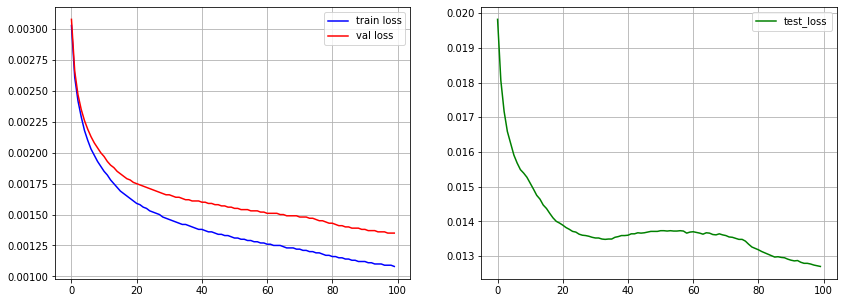

CPU times: user 3h 46min 5s, sys: 21min 56s, total: 4h 8min 2s
Wall time: 1h 46min 11s


In [17]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [18]:
def get_prediction_errors(teacher, student, data):
    teacher.eval()
    student.eval()
    loss = []
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss.append(reverse_kl(teacher_pred, student_pred).item())
    return loss

In [19]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))

In [20]:
y_true = [1] * len(mnist_prediction_errors) + [0] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.9911250783333334

Epoch 150
Train loss:	 0.00097
Val loss:	 0.00124
Test loss:	 0.01206


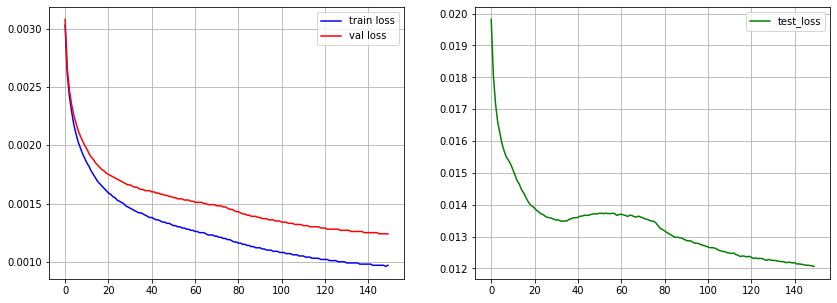

CPU times: user 3h 45min 18s, sys: 22min 6s, total: 4h 7min 25s
Wall time: 1h 43min 14s


In [21]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 200
Train loss:	 0.00085
Val loss:	 0.00111
Test loss:	 0.01051


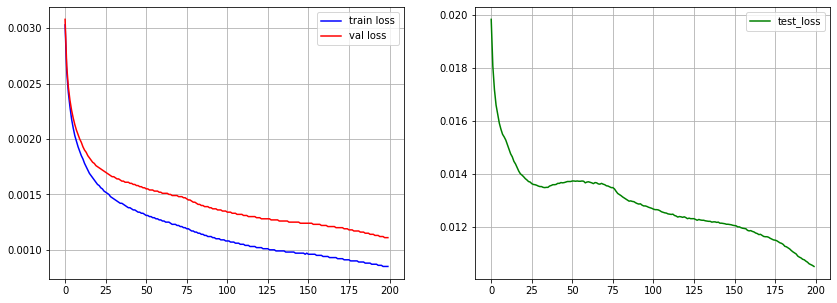

CPU times: user 3h 41min 6s, sys: 21min 40s, total: 4h 2min 47s
Wall time: 1h 40min 31s


In [22]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 250
Train loss:	 0.00073
Val loss:	 0.00095
Test loss:	 0.009


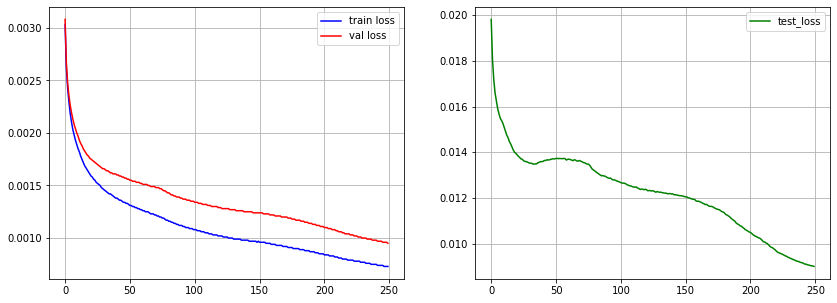

CPU times: user 4h 35min 36s, sys: 21min 49s, total: 4h 57min 25s
Wall time: 1h 36min 42s


In [23]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

Epoch 350
Train loss:	 0.0006
Val loss:	 0.0008
Test loss:	 0.00775


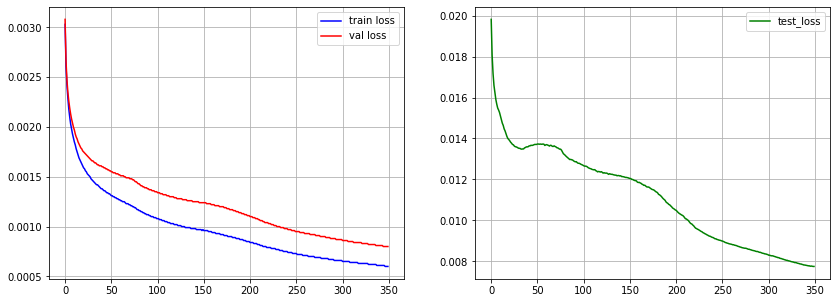

CPU times: user 11h 16min 20s, sys: 39min 27s, total: 11h 55min 47s
Wall time: 3h 2min 10s


In [24]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=100)

Epoch 500
Train loss:	 0.00033
Val loss:	 0.00044
Test loss:	 0.0053


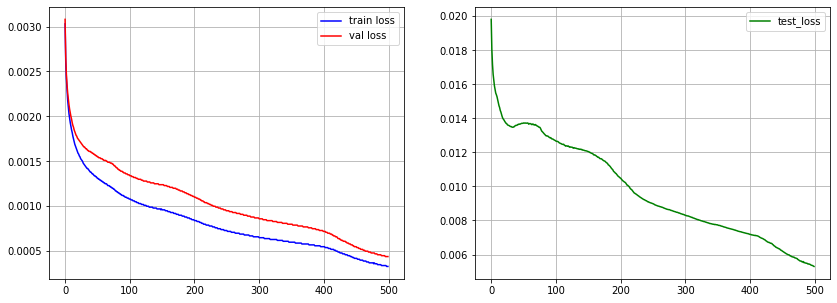

CPU times: user 19h 59min 48s, sys: 15min 41s, total: 20h 15min 30s
Wall time: 3h 53min


In [25]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=150)

In [27]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [1] * len(mnist_prediction_errors) + [0] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.9922883908333333

#### saving the figure

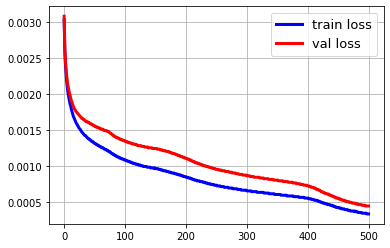

In [28]:
plt.plot(train_log, label='train loss', c='b', linewidth=3)
plt.plot(val_log, label='val loss', c='r', linewidth=3)
plt.grid()
plt.legend(loc='best', fontsize=13)
plt.savefig('learning_curves_train_fashion_to_original.pdf')

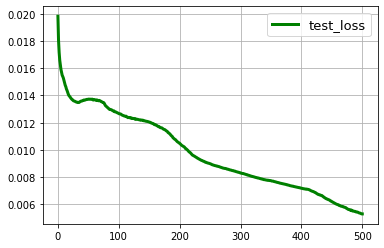

In [29]:
plt.plot(test_log, label='test_loss', c='g', linewidth=3)
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.savefig('learning_curves_test_fashion_to_original.pdf')